In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings

filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

import xgboost as xgb

np.random.seed(42)
sns.set_style("whitegrid")

print("All imports successful! ✅")
print(f"XGBoost version: {xgb.__version__}")

All imports successful! ✅
XGBoost version: 3.1.1


## 1. Load Data and Separate Labeled/Unlabeled


In [2]:
# Load data
df = pd.read_csv("Analytica.csv")

print(f"Total samples: {len(df)}")
print(f"Labeled samples (non-NaN target): {df['target'].notna().sum()}")
print(f"Unlabeled samples (NaN target): {df['target'].isna().sum()}")

# Separate labeled and unlabeled data
df_labeled = df[df["target"].notna()].copy()
df_unlabeled = df[df["target"].isna()].copy()

print(f"\nLabeled data shape: {df_labeled.shape}")
print(f"Unlabeled data shape: {df_unlabeled.shape}")

Total samples: 34163
Labeled samples (non-NaN target): 5096
Unlabeled samples (NaN target): 29067

Labeled data shape: (5096, 112)
Unlabeled data shape: (29067, 112)


In [3]:
# Check class distribution in labeled data
print("Class distribution in labeled data:")
print(df_labeled["target"].value_counts())
print(f"\nClass balance: {df_labeled['target'].mean():.2%} are class 1")

Class distribution in labeled data:
target
0.0    2683
1.0    2413
Name: count, dtype: int64

Class balance: 47.35% are class 1


## 2. Prepare Features


In [4]:
# Extract features (exclude ID and target)
feature_cols = [col for col in df.columns if col not in ["ID", "target"]]
print(f"Number of features: {len(feature_cols)}")

# Prepare training data from labeled examples
X_train_full = df_labeled[feature_cols].values
y_train_full = df_labeled["target"].values.astype(int)

# Prepare test data (unlabeled examples to predict)
X_test = df_unlabeled[feature_cols].values
unlabeled_ids = df_unlabeled["ID"].values

print(f"Training data shape: {X_train_full.shape}")
print(f"Test data shape: {X_test.shape}")

Number of features: 110
Training data shape: (5096, 110)
Test data shape: (29067, 110)


In [5]:
# Scale features - fit on labeled data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test)

print(
    f"Scaled training data - Mean: {X_train_scaled.mean():.4f}, Std: {X_train_scaled.std():.4f}"
)

Scaled training data - Mean: 0.0000, Std: 1.0000


## 3. Train/Validation Split for Model Evaluation


In [6]:
# Split labeled data for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_scaled, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")

Training set: 4076 samples
Validation set: 1020 samples


## 4. Train XGBoost Model


In [7]:
# Train XGBoost classifier
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss",
    use_label_encoder=False,
)

model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

print("Model trained successfully! ✅")

Model trained successfully! ✅


## 5. Evaluate Model on Validation Set


In [8]:
# Predictions on validation set
y_val_pred = model.predict(X_val)
y_val_proba = model.predict_proba(X_val)[:, 1]

# Metrics
accuracy = accuracy_score(y_val, y_val_pred)
roc_auc = roc_auc_score(y_val, y_val_proba)

print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation ROC-AUC: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))

Validation Accuracy: 0.8225
Validation ROC-AUC: 0.9051

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       537
           1       0.81      0.81      0.81       483

    accuracy                           0.82      1020
   macro avg       0.82      0.82      0.82      1020
weighted avg       0.82      0.82      0.82      1020



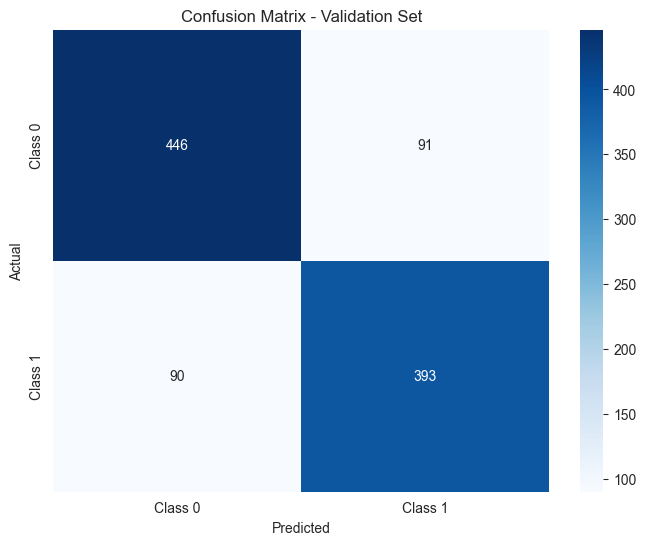

In [9]:
# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Class 0", "Class 1"],
    yticklabels=["Class 0", "Class 1"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Validation Set")
plt.show()

## 6. Cross-Validation Score


In [10]:
# Cross-validation on full labeled data
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    xgb.XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric="logloss",
        use_label_encoder=False,
    ),
    X_train_scaled,
    y_train_full,
    cv=cv,
    scoring="roc_auc",
)

print(f"Cross-Validation ROC-AUC Scores: {cv_scores}")
print(f"Mean CV ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Cross-Validation ROC-AUC Scores: [0.91298179 0.90897641 0.91234923 0.91482031 0.91360743]
Mean CV ROC-AUC: 0.9125 (+/- 0.0039)


## 7. Feature Importance


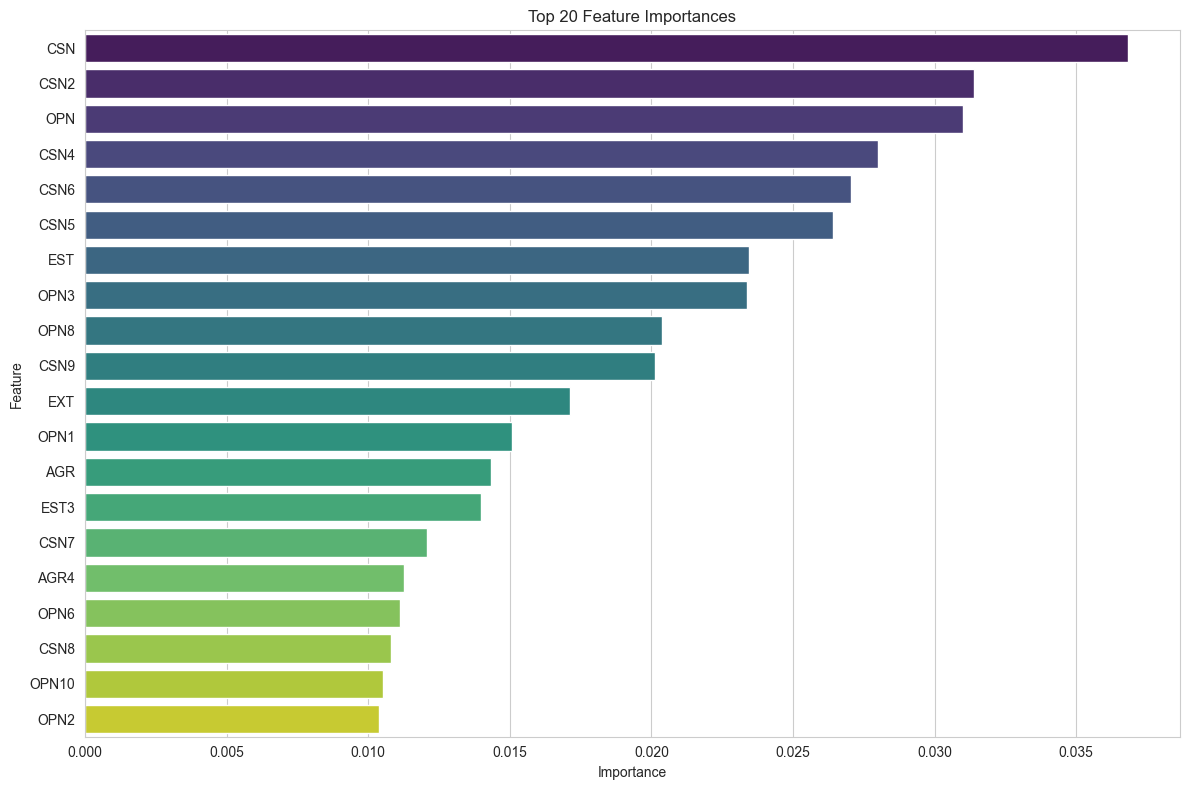

In [11]:
# Feature importance
importance = model.feature_importances_
feature_importance = pd.DataFrame(
    {"Feature": feature_cols, "Importance": importance}
).sort_values(by="Importance", ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 8))
sns.barplot(
    data=feature_importance.head(20), x="Importance", y="Feature", palette="viridis"
)
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()

## 8. Retrain on Full Labeled Data and Predict


In [12]:
# Retrain on all labeled data for final predictions
final_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss",
    use_label_encoder=False,
)

final_model.fit(X_train_scaled, y_train_full, verbose=False)
print("Final model trained on all labeled data! ✅")

Final model trained on all labeled data! ✅


In [13]:
# Predict on unlabeled data
predictions = final_model.predict(X_test_scaled)
predictions_proba = final_model.predict_proba(X_test_scaled)[:, 1]

print(f"Predictions made: {len(predictions)}")
print(f"Predicted class distribution:")
print(pd.Series(predictions).value_counts())

Predictions made: 29067
Predicted class distribution:
0    15717
1    13350
Name: count, dtype: int64


## 9. Create Submission File


In [14]:
# Create submission dataframe
submission = pd.DataFrame({"ID": unlabeled_ids, "prediction": predictions})

print("Submission preview:")
submission.head(10)

Submission preview:


,ID,prediction
0,20160303022202,1
1,20160303052049,1
2,20160303052319,0
3,20160303055318,0
4,20160303063505,1
5,20160303064930,1
6,20160303070035,1
7,20160303080108,1
8,20160303080415,1
9,20160303084611,1


In [15]:
# Save submission
submission.to_csv("submit_xgboost_supervised.csv", index=False)
print("Submission saved to submit_xgboost_supervised.csv ✅")
print(f"Total predictions: {len(submission)}")

Submission saved to submit_xgboost_supervised.csv ✅
Total predictions: 29067
